# X-ray Fluorescence Analysis 
    Python Driving License Project
    Aixeen Manuel Fontanilla | PhD STEN 38th Cycle

#### The goals of the project are:

    (1) Derive the xray spectrum of the RTC 1000-HS X-ray tube at 70 kVp from Spekpy
    (2) Import the X-ray spectra derived from the output of Monte Carlo simulations (MCNP6, FLUKA)
    (3) Process each spectrum to be achieve a normalized x-ray fluence (photons/sp/keV/cm2)
    (4) Generate XRF/X-ray interaction data through the XRAYLIB library
    (5) Import a characteristic spectrum of a Pt sample from an experiment and its fitted area.
    (6) Calculate concentration of Pt from the XRF spectrum using the Fundamental Parameters method.

## I. X-ray tube spectrum from Spekpy

In [17]:
import matplotlib.pyplot as plt # Import library for plotting
import numpy as np
import spekpy as sp # Import SpekPy

spectrum name
C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/xray_tube_spectrum_70kV_spekpy.txt


<IPython.core.display.Javascript object>


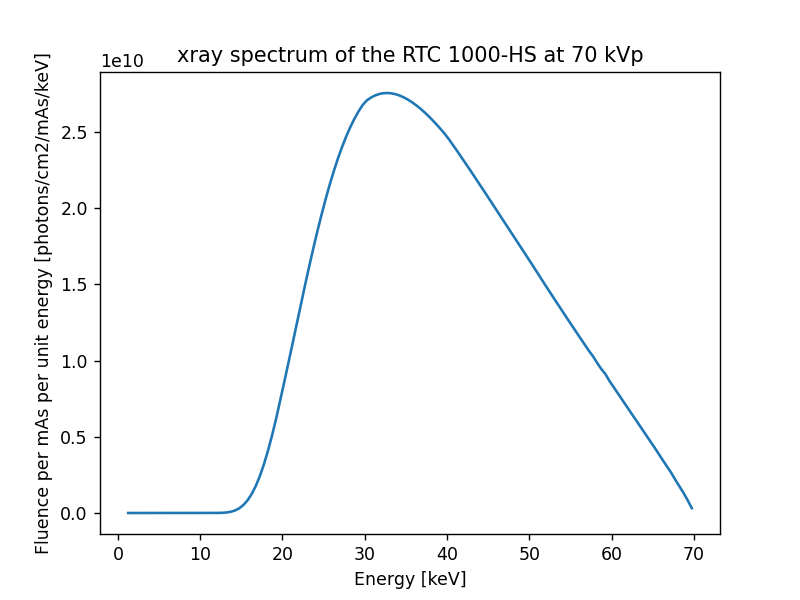

In [88]:
# Select the appropriate X-ray tube settings and irradiation parameters
s = sp.Spek(kvp=70,th=13, targ="W", z=43, mas=1380,  physics= "kqp", mu_data_source = "nist")

# Apply the inherent tube filtration
tube_filtration = 2.4
s=s.filter('Al', tube_filtration)

# Generate the spectrum
k, f = s.get_spectrum(edges=False, flu=True, diff=True)

# Save the generated spectrum in a txt file
spek_name = "C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/xray_tube_spectrum_70kV_spekpy.txt"
s.export_spectrum(spek_name, comment='Xray spectrum for the tube at 70 kVp', delim='\t')

# Plotting 
plt.figure()
plt.plot(k, f) # Plot the spectrum
plt.xlabel('Energy [keV]')
plt.ylabel('Fluence per mAs per unit energy [photons/cm2/mAs/keV]')
plt.title('xray spectrum of the RTC 1000-HS at 70 kVp')
plt.show()

## II. Import X-ray spectra from Simulations

In [91]:
# Define a function to load the spectrum outputs
# Note: Except for FLUKA, other simulation outputs has the same output [Column 0: energy, Column 1: tally score]
# General processing for Spekpy and PyMCA except for MCNP which has energy units in MeV

def load_xray_spectrum(file_path, header_lines=0,footer_lines=0, processing_function=None):
    data = np.genfromtxt(file_path, dtype=float, usecols=(0, 1), skip_header=header_lines,skip_footer=footer_lines)
    energy = data[:, 0]
    xray_weight0 = data[:, 1]

    if processing_function is not None:
        energy, xray_weight0 = processing_function(energy, xray_weight0)

    delta_energy = np.diff(energy)
    delta_energy = np.insert(delta_energy, delta_energy.size, 0)
    sum_total = np.sum(xray_weight0 * delta_energy)
    normalized_spectrum = xray_weight0 / sum_total
    return energy, normalized_spectrum

#For FLUKA output file with different format and processing, specific function will be defined
def load_fluka_spectrum(file_path, header_lines=0):
    data = np.genfromtxt(file_path, dtype=float, usecols=(0, 1, 2), skip_header=header_lines)
    energy_lower = data[:, 0]
    energy_upper = data[:, 1]
    xray_weight0 = data[:, 2]

    return energy_lower, energy_upper, xray_weight0



## ============================================================================================================================#
# Define a function that processes each of the input files
def fluka_processing(energy_lower, energy_upper, xray_weight0):
    # Calculate the average energy
    E_ave = (energy_lower + energy_upper) / 2

    # Calculate the sum of weights times energy intervals
    delta_energy = energy_upper - energy_lower
    sum_total = np.sum(xray_weight0 * delta_energy)

    # Normalize the spectrum
    normalized_spectrum = (xray_weight0)/ sum_total

    return E_ave, normalized_spectrum

def spekpy_processing(energy, xray_weight0):
    return energy, xray_weight0

def pymca_processing(energy, xray_weight0):
    return energy, xray_weight0

def mcnp_processing(energy, xray_weight0):
    E_mcnp = energy*1000
    delta_energy = np.diff(E_mcnp)
    delta_energy = np.insert(delta_energy, delta_energy.size, 0)
    sum_total = np.sum(xray_weight0 * delta_energy)
    normalized_spectrum = xray_weight0 / (sum_total)
    
    return E_mcnp, xray_weight0


## III. Process the inherent X-ray Spectra

<IPython.core.display.Javascript object>


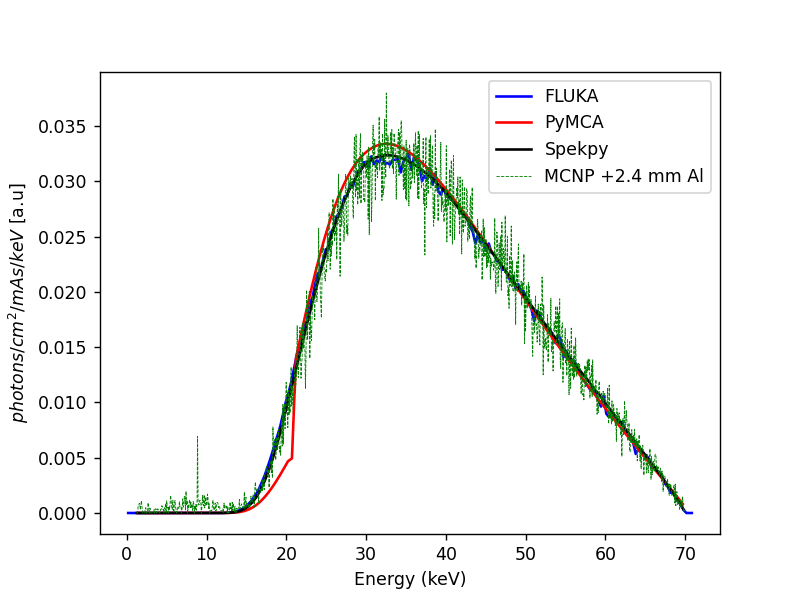

In [92]:
# File path FLUKA
inh_fluka_file = "C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/inherent_spectrum_70kV.txt"

# File path for MCNP, PyMCA and SpekPy
inh_pymca_file = "C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/xray_tube_spectrum_70kV_pymca.txt"
inh_spekpy_file = "C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/xray_spectrum_spekpy.spk"
inh_mcnp_file_24mmAl = "C:/Users/Aixeen Fontanilla/Desktop/RETINA_mcnp/70kV/Inherent filter thickness 24mm/70kV_filtered_24mmAl.txt"

# Load FLUKA data
energy_lower, energy_upper, xray_weight0 = load_fluka_spectrum(inh_fluka_file)
E_ave, inh_xray_spec = fluka_processing(energy_lower, energy_upper, xray_weight0)

#Load MCNP, PyMCA, and Spekpy data
E_cen, inh_xray_spekpy = load_xray_spectrum(inh_spekpy_file, header_lines=16, processing_function=spekpy_processing)
E_pymca, inh_xray_spec_py = load_xray_spectrum(inh_pymca_file, header_lines=4, processing_function=pymca_processing)
E_mcnp2, inh_xray_spec_mcnp_24mmAl = load_xray_spectrum(inh_mcnp_file_24mmAl, header_lines=6, footer_lines=1, processing_function=mcnp_processing)



#==============================================================================================================================#
# Normalized spectra plotting
plt.figure(1)
plt.plot(E_ave, inh_xray_spec, linestyle='solid', color ="b", label ="FLUKA")
plt.plot(E_pymca[1:], inh_xray_spec_py[0:len(inh_xray_spec_py)-1],  linestyle='solid', color ="r", label="PyMCA")
plt.plot(E_cen,inh_xray_spekpy,  linestyle='solid', color ="black", label="Spekpy")
plt.plot(E_mcnp2,inh_xray_spec_mcnp_24mmAl,  linestyle='dashed',linewidth=0.5, color ="green", label="MCNP +2.4 mm Al")
plt.legend(loc="best")
plt.xlabel('Energy (keV)')
plt.ylabel(r'$photons/cm^2/mAs/keV$ [a.u]' )
plt.savefig('C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/xray_spectrum.png')

## IV. X-ray Cross-sections from xraylib

In [93]:
# Import standard Python libraries for scientific analysis and plotting
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import sys

# Import XRAYLIB
import xraylib as xrl
import xraylib_np as xrl_np

In [94]:
#---USER DEFINITIONS---#

# Define the folder in which the data will be saved
folder = "C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/"

# Define list of symbols of the elements
elements = ['Pt','Ce']

# Define the vector of energies [keV] in which the cross-sections will be calculated
# Here we choose to use the FLUKA spectrum
energies_user = E_ave #[keV]


In [95]:
#---SET VARIABLES---#

# Obtain array of element atomic numbers
Z = np.array([xrl.SymbolToAtomicNumber(j) for j in elements])

#Define the shells to be considered per element
K = xrl.K_SHELL
L1 = xrl.L1_SHELL
L2 = xrl.L2_SHELL
L3 = xrl.L3_SHELL

# Define the shell transitions 
K_transitions = np.array([xrl.KL3_LINE, xrl.KL2_LINE, xrl.KM3_LINE, xrl.KM2_LINE])
K_transition_names = ['K_alpha1', 'K_alpha2', 'K_beta1', 'K_beta3']
L_transitions = np.array([xrl.L1M3_LINE, xrl.L2M4_LINE, xrl.L2N4_LINE, xrl.L3M5_LINE, xrl.L3N4_LINE, xrl.L3M1_LINE])
L_transition_names = ['L_beta3', 'L_beta1', 'L_gamma1', 'L_alpha1', 'L_beta2', 'L_l']
transitions = np.concatenate((K_transitions, L_transitions))

# Create an array of the assigned shells and their corresponding names
shells = np.array([K, L1, L2, L3])
shell_names = ["K", "L1", "L2", "L3"]


**Average energy of fluorescence photons**

The average energy of fluorescence photons of the i-th shell (K or L) is calculated as a weighted sum over all the lines:

$$E_{avg,i}(E)=\frac{\sum_{j} E_{XRF,i,j}*\sigma_{XRF,i,j}(E)}{\sum_{j} \sigma_{XRF,i,j}(E)}$$

<IPython.core.display.Javascript object>


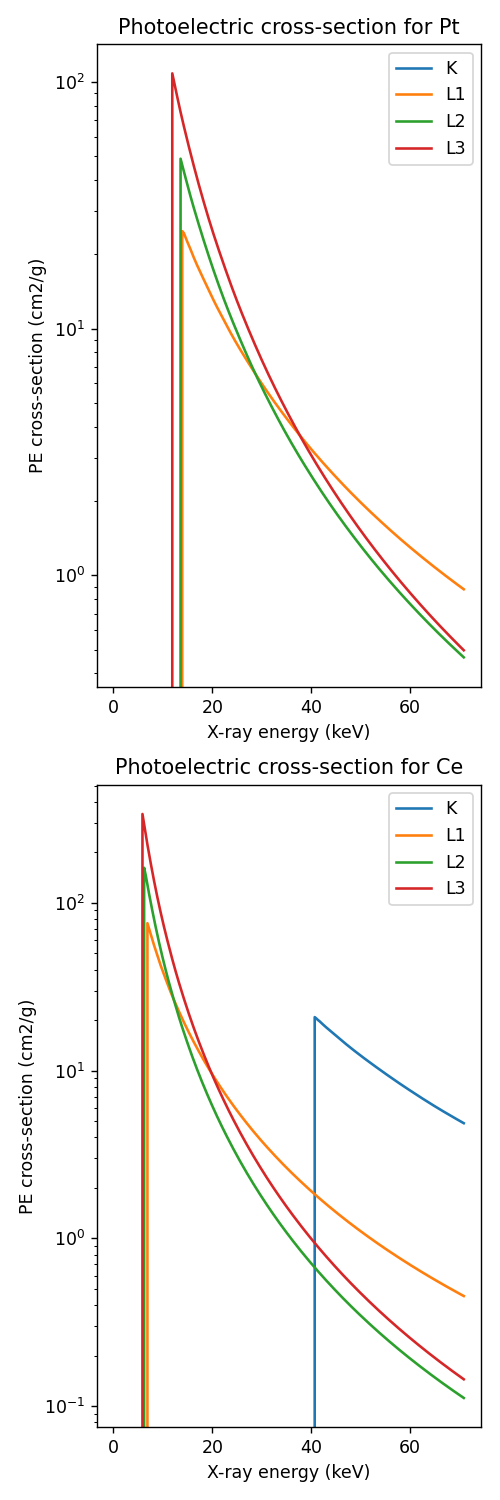

In [96]:
# Obtain photoelectric cross-sections for all desired shells
PE_CS_arr = xrl_np.CS_Photo_Partial(Z, shells, energies_user) # [cm2/g]

# Plot partial photoelectric cross-sections for each shell
figure_1, axes_1 = plt.subplots(nrows=len(elements), ncols=1, figsize=(4, 12))

for i in range(0, len(elements)):
    for j in range(0,len(shells)):
        axes_1[i].plot(energies_user, PE_CS_arr[i, j, :], label = shell_names[j])
        axes_1[i].set_yscale("log")
        axes_1[i].set_xlabel('X-ray energy (keV)')
        axes_1[i].set_ylabel('PE cross-section (cm2/g)')
        axes_1[i].set_title('Photoelectric cross-section for {}'.format(elements[i]));
        axes_1[i].legend(loc=0);
figure_1.tight_layout()


<IPython.core.display.Javascript object>


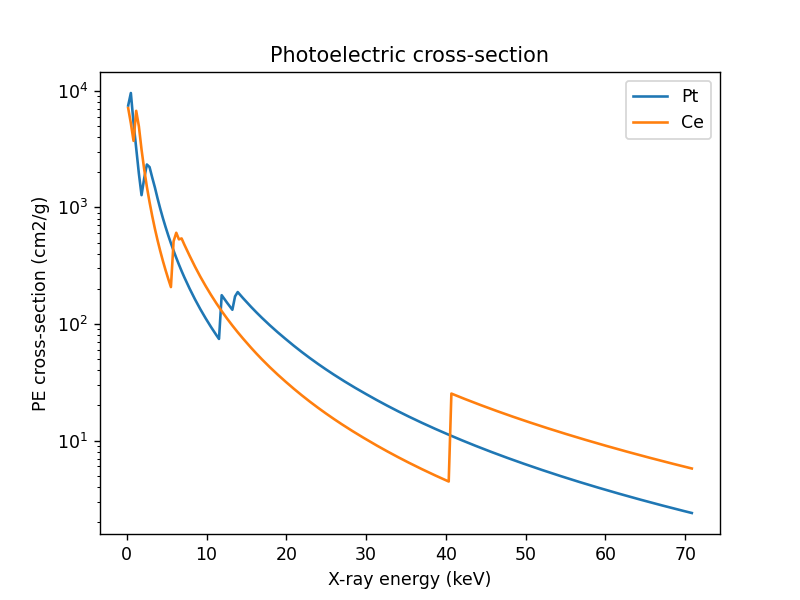

In [97]:
# Obtain total photoelectric cross-sections
PE_CS_tot_arr = xrl_np.CS_Photo(Z, energies_user) # [cm2/g] -- CSb if in barns

# Plot total photoelectric cross-sections
figure_2, axes_2 = plt.subplots()

for i in range(0, len(elements)):
    axes_2.plot(energies_user, PE_CS_tot_arr[i, :], label = elements[i])
    axes_2.set_yscale("log")
    axes_2.set_xlabel('X-ray energy (keV)')
    axes_2.set_ylabel('PE cross-section (cm2/g)')
    axes_2.set_title('Photoelectric cross-section');
    axes_2.legend(loc=0);


<IPython.core.display.Javascript object>


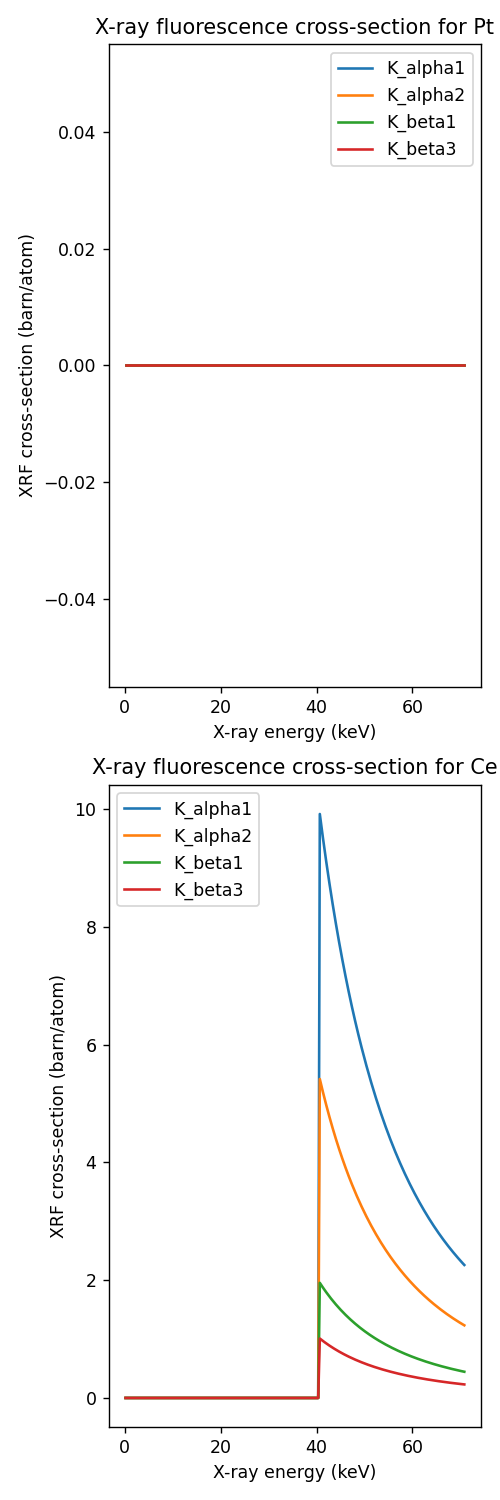

In [98]:
#---PLOT K-SHELL XRF CROSS-SECTIONS AND MEAN FLUORESCENCE ENERGY---#

# Obtain XRF line energy for all desired K-shell transitions
K_line_en_arr = xrl_np.LineEnergy(Z, K_transitions) # [keV]
# Obtain XRF cross-sections for all desired K-shell transitions
K_XRF_CS_arr = xrl_np.CS_FluorLine(Z, K_transitions, energies_user) # [cm^2/g]

# Plot XRF cross-sections
figure_3, axes_3 = plt.subplots(nrows=len(elements), ncols=1, figsize=(4, 12))

for i in range(0, len(elements)):
    for j in range(0,len(K_transitions)):
        axes_3[i].plot(energies_user, K_XRF_CS_arr[i, j, :], label = K_transition_names[j])
        #axes_3[i].set_yscale("log")
        #axes_3[i].set_xscale("log")
        axes_3[i].set_xlabel('X-ray energy (keV)')
        axes_3[i].set_ylabel('XRF cross-section (barn/atom)')
        axes_3[i].set_title('X-ray fluorescence cross-section for {}'.format(elements[i]));
        axes_3[i].legend(loc=0);
figure_3.tight_layout()



<IPython.core.display.Javascript object>


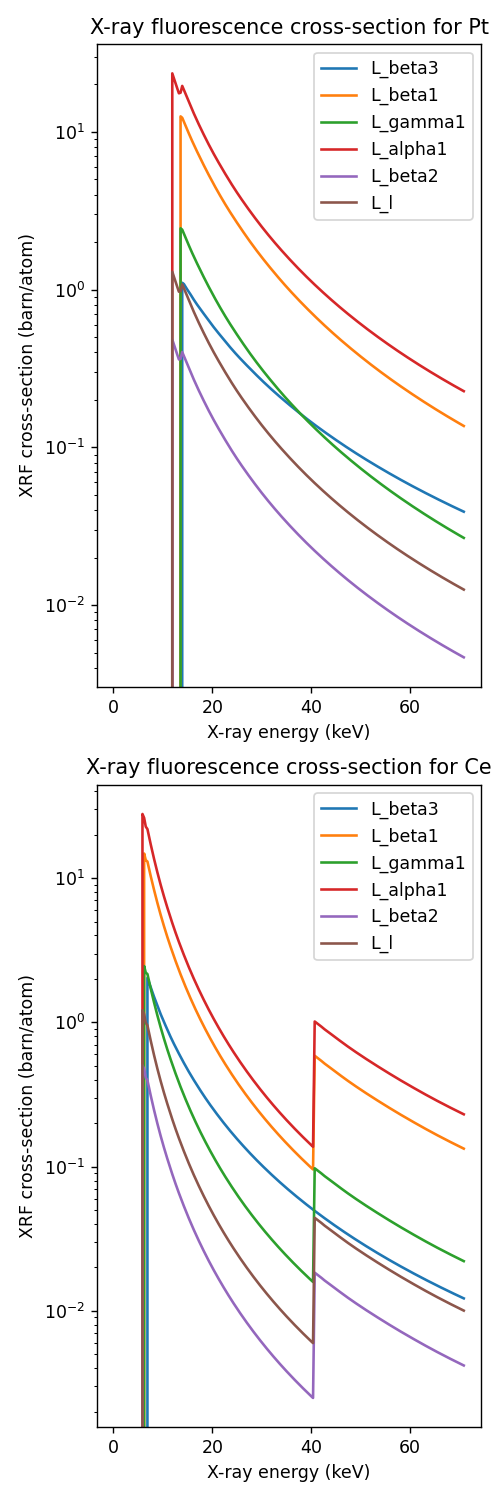

In [99]:
#---PLOT K-SHELL XRF CROSS-SECTIONS AND MEAN FLUORESCENCE ENERGY---#

# Obtain XRF line energy for all desired K-shell transitions
L_line_en_arr = xrl_np.LineEnergy(Z, L_transitions) # [keV]
# Obtain XRF cross-sections for all desired K-shell transitions
L_XRF_CS_arr = xrl_np.CS_FluorLine_Kissel_Radiative_Cascade(Z, L_transitions, energies_user) # [cm^2/g]



# Plot XRF cross-sections
figure_3, axes_3 = plt.subplots(nrows=len(elements), ncols=1, figsize=(4, 12))

for i in range(0, len(elements)):
    for j in range(0,len(L_transitions)):
        axes_3[i].plot(energies_user, L_XRF_CS_arr[i, j, :], label = L_transition_names[j])
        axes_3[i].set_yscale("log")
        #axes_3[i].set_xscale("log")
        axes_3[i].set_xlabel('X-ray energy (keV)')
        axes_3[i].set_ylabel('XRF cross-section (barn/atom)')
        axes_3[i].set_title('X-ray fluorescence cross-section for {}'.format(elements[i]));
        axes_3[i].legend(loc=0);
figure_3.tight_layout()

## V.  Import a characteristic spectrum of a Pt sample

<IPython.core.display.Javascript object>


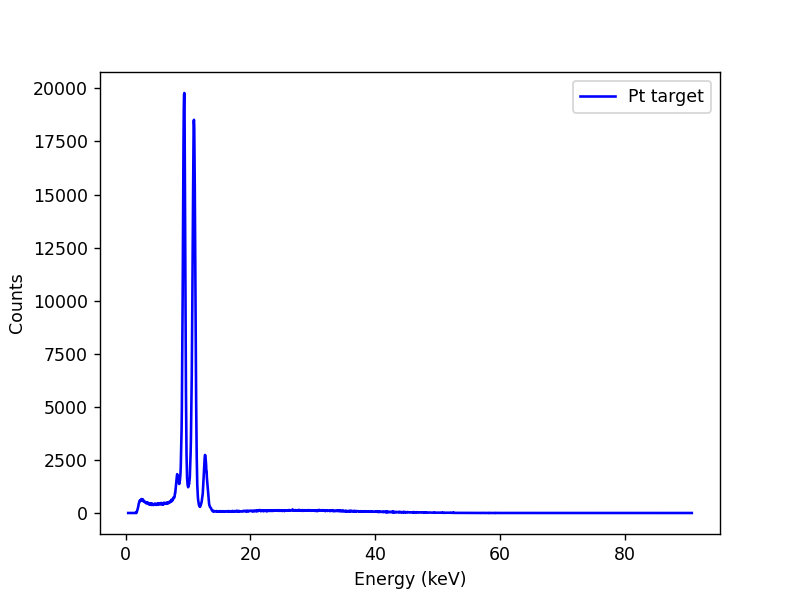

In [100]:
# Import XRF spectrum
xrf_spe = folder + "Run001_Right.Spe"
xrf_spectrum = np.genfromtxt(fname = xrf_spe, dtype=float, usecols=(0), skip_header=11, skip_footer = 18)
channel_xrf = np.arange(0,2049)
en_xrf = 0.426172+ 0.044089*channel_xrf


# Plot XRF spectrum
plt.figure()
plt.plot(en_xrf, xrf_spectrum, linestyle='solid', color ="b", label ="Pt target")
plt.legend(loc="best")
plt.xlabel('Energy (keV)')
plt.ylabel(r'Counts' )

# Import fitted areas per emission line

xray_spec_fit = folder + "Pt_target_pymca_fit.txt"
E_shells = np.genfromtxt(fname = xray_spec_fit, dtype=float, usecols=(3), skip_header=0)
I_fit_area = np.genfromtxt(fname = xray_spec_fit, dtype=float, usecols=(1), skip_header=0)



## VI. Derive the Concentrations using FPM

The fundamental parameters method is based on:

   $$
        A = I_{o} C \frac{\Omega}{4\pi}\Sigma_{j}R_{j}"
   $$

In [101]:
#Retrieve X-ray spectrum energy and probability density from FLUKA

xray_spec = "C:/Users/Aixeen Fontanilla/Desktop/X-ray Spectrum Py/X-ray Spec/inherent_spectrum_70kV.txt"
xray_weight0=np.genfromtxt(fname = xray_spec, dtype=float, usecols=(2), skip_header=0)

# Define the efficiencies per energy in an array
efficiencies = [0.9296, 0.9438, 0.9444, 0.9444, 0,94, 0.942] #calculated detection efficiency of CZT
t_irr =600    #irradiation time

# Initialize a dictionary to store the concentrations and XS_I
concentrations = {}
XS_I = {} #cross section and x-ray weight product
fit_areas = {}

# Iterate and loop over over the L-shell lines and calculate the concentration
for i, shell_name in enumerate(L_transition_names):
    xrf_cs = L_XRF_CS_arr[0, i]
    L_concentration = f'{shell_name}_Q'
    energy_efficiency = efficiencies[i]
    XS_I = xrf_cs * xray_weight0
    
    concentration = I_fit_area[i] / (t_irr * energy_efficiency * np.trapz(XS_I))
    concentrations[L_concentration] = concentration
    fit_areas[L_concentration] = I_fit_area[i]

# Print the concentrations and fit areas
for L_concentration, concentration in concentrations.items():
    print(f'{L_concentration} Concentration: {concentration}, Fit Area: {fit_areas[L_concentration]}')


L_beta3_Q Concentration: 1.2885097503008403, Fit Area: 22028.0
L_beta1_Q Concentration: 1.2754107434845676, Fit Area: 135760.0
L_gamma1_Q Concentration: 1.158702069470759, Fit Area: 24087.0
L_alpha1_Q Concentration: 1.0602570268975193, Fit Area: 177060.0
L_beta2_Q Concentration: inf, Fit Area: 19955.0
L_l_Q Concentration: 0.009440675736687784, Fit Area: 8661.5


#### Solution: modified XRF cross section as spectra combines some L-lines together

In [102]:
# Define the efficiencies per energy in an array
efficiencies = [0.9296, 0.9438, 0.9444, 0.9444, 0.94, 0.942]
t_irr = 600

# Initialize dictionaries to store concentrations and fit areas
concentrations = {}
fit_areas = {}

# Define a function to calculate concentrations for specific transition groupings
def calculate_concentration(group_name, group_transitions):
    combined_XS_I = sum(L_XRF_CS_arr[0, L_transition_names.index(trans)] * xray_weight0 for trans in group_transitions)
    combined_fit_area = sum(I_fit_area[L_transition_names.index(trans)] for trans in group_transitions)
    energy_efficiency = efficiencies[L_transition_names.index(group_transitions[0])]
    concentration = combined_fit_area / (t_irr * energy_efficiency * np.trapz(combined_XS_I))
    concentrations[group_name] = concentration
    fit_areas[group_name] = combined_fit_area

# Define transition groupings and call the function for each grouping
groupings = {
    'L_beta_combined_Q': ['L_beta3', 'L_beta1'],
    'L_alpha_combined_Q': ['L_alpha1', 'L_beta2']
}

for group_name, group_transitions in groupings.items():
    calculate_concentration(group_name, group_transitions)

# Iterate over the L-shell lines and calculate individual concentrations
for i, shell_name in enumerate(L_transition_names):
    xrf_cs = L_XRF_CS_arr[0, i]
    L_concentration = f'{shell_name}_Q'
    energy_efficiency = efficiencies[i]
    XS_I = xrf_cs * xray_weight0

    concentration = I_fit_area[i] / (t_irr * energy_efficiency * np.trapz(XS_I))
    concentrations[L_concentration] = concentration
    fit_areas[L_concentration] = I_fit_area[i]

# Print the concentrations and fit areas
for L_concentration, concentration in concentrations.items():
    print(f'{L_concentration} Concentration: {concentration}, Fit Area: {fit_areas[L_concentration]}')


L_beta_combined_Q Concentration: 1.293998187739409, Fit Area: 157788.0
L_alpha_combined_Q Concentration: 1.1560140766594404, Fit Area: 197015.0
L_beta3_Q Concentration: 1.2885097503008403, Fit Area: 22028.0
L_beta1_Q Concentration: 1.2754107434845676, Fit Area: 135760.0
L_gamma1_Q Concentration: 1.158702069470759, Fit Area: 24087.0
L_alpha1_Q Concentration: 1.0602570268975193, Fit Area: 177060.0
L_beta2_Q Concentration: 5.846920951254446, Fit Area: 19955.0
L_l_Q Concentration: 0.9420631839157663, Fit Area: 8661.5


<IPython.core.display.Javascript object>


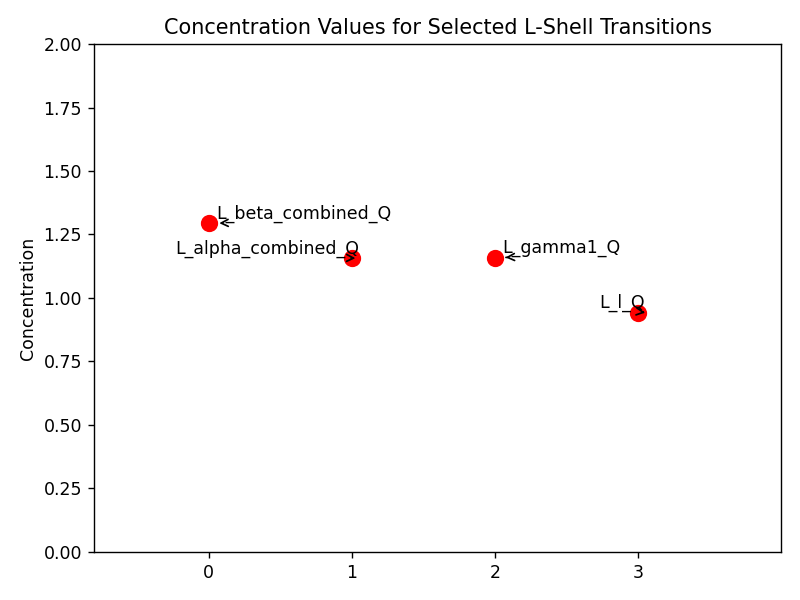

In [103]:
from adjustText import adjust_text  # Import the adjust_text library

# Define the indices of the values to plot
indices_to_plot = [0, 1, 4, 7]  

# Extract concentration values and transition names for the specified indices
concentration_values = [concentrations[name] for i, name in enumerate(transition_names) if i in indices_to_plot]
transition_names_to_plot = [transition_names[i] for i in indices_to_plot]

# Create a scatter plot
plt.figure()
scatter = plt.scatter(range(len(concentration_values)), concentration_values, marker='o', color="r",s=80, label="Concentration")

# Label each data point with the corresponding transition name
labels = []
for i, name in enumerate(transition_names_to_plot):
    label_x = i+0.05 # Adjust the x-coordinate of the label
    label_y = concentration_values[i]  # Adjust the y-coordinate of the label
    labels.append(plt.text(label_x, label_y, name, ha='right'))  # Specify 'right' alignment for labels

# Set the x-axis labels to the specified transition names
x_positions = list(range(len(transition_names_to_plot)))
x_labels = np.arange(len(indices_to_plot))
plt.xticks(x_positions, x_labels)


# Automatically adjust the data point labels to prevent overlapping
adjust_text(labels, only_move={'points': 'y', 'text': 'y'}, arrowprops=dict(arrowstyle="->", color='black', lw=1))
    
# Set the x-axis labels to the specified transition names
plt.ylim(0,2)
plt.xlim(-0.8,4)
plt.ylabel('Concentration')
plt.title('Concentration Values for Selected L-Shell Transitions')
plt.tight_layout()
plt.show()